In [1]:
#@title ◢ Git clone and install DeOldify
%cd /content/
#!git clone https://github.com/jantic/DeOldify.git DeOldify 
!git clone https://github.com/styler00dollar/Colab-DeOldify DeOldify
%cd DeOldify
#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU0)

import torch

if not torch.cuda.is_available():
    print('GPU not available.')
!pip install -r colab_requirements.txt
import fastai
from deoldify.visualize import *
!mkdir 'models'

#!wget https://deepai-opensource-codebases-models.s3-us-west-2.amazonaws.com/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth
!wget https://www.dropbox.com/s/usf7uifrctqw9rl/ColorizeStable_gen.pth?dl=0 -O ./models/ColorizeStable_gen.pth
!wget https://media.githubusercontent.com/media/jantic/DeOldify/master/resource_images/watermark.png -O ./resource_images/watermark.png

colorizer = get_image_colorizer(artistic=True)

/content
Cloning into 'DeOldify'...
remote: Enumerating objects: 2208, done.
remote: Total 2208 (delta 0), reused 0 (delta 0), pack-reused 2208
Receiving objects: 100% (2208/2208), 104.73 MiB | 23.52 MiB/s, done.
Resolving deltas: 100% (975/975), done.
/content/DeOldify
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 13.2 MB/s 
     |████████████████████████████████| 129 kB 71.3 MB/s 
     |████████████████████████████████| 1.9 MB 67.6 MB/s 
     |████████████████████████████████| 8.8 MB 72.0 MB/s 
     |████████████████████████████████| 355 kB 53.9 MB/s 
     |████████████████████████████████| 78 kB 9.2 MB/s 
     |████████████████████████████████| 363 kB 78.0 MB/s 
     |████████████████████████████████| 423 kB 78.2 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 9.8 MB 42.6 MB/s 
     |████████████████████████████████| 133 kB 79.0 MB

--2023-01-03 07:29:43--  https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth
Resolving data.deepai.org (data.deepai.org)... 84.17.46.53, 2400:52e0:1e01::879:1
Connecting to data.deepai.org (data.deepai.org)|84.17.46.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255144681 (243M) [application/octet-stream]
Saving to: ‘./models/ColorizeArtistic_gen.pth’

./models/ColorizeAr 100%[===================>] 243.32M   184MB/s    in 1.3s    

2023-01-03 07:29:44 (184 MB/s) - ‘./models/ColorizeArtistic_gen.pth’ saved [255144681/255144681]

--2023-01-03 07:29:44--  https://www.dropbox.com/s/usf7uifrctqw9rl/ColorizeStable_gen.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/usf7uifrctqw9rl/ColorizeStable_gen.pth [following]
--2023-01-03 07:29:45--  https://www.dropbox.c

/usr/local/lib/python3.8/dist-packages/fastai/data_block.py:442: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.8/dist-packages/fastai/data_block.py:444: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid pot

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/content/DeOldify


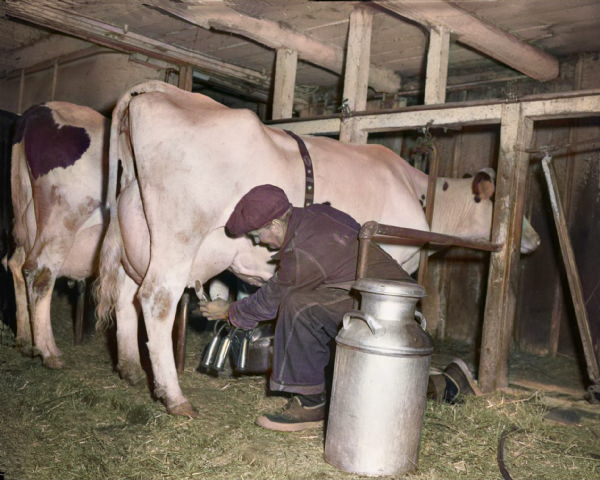

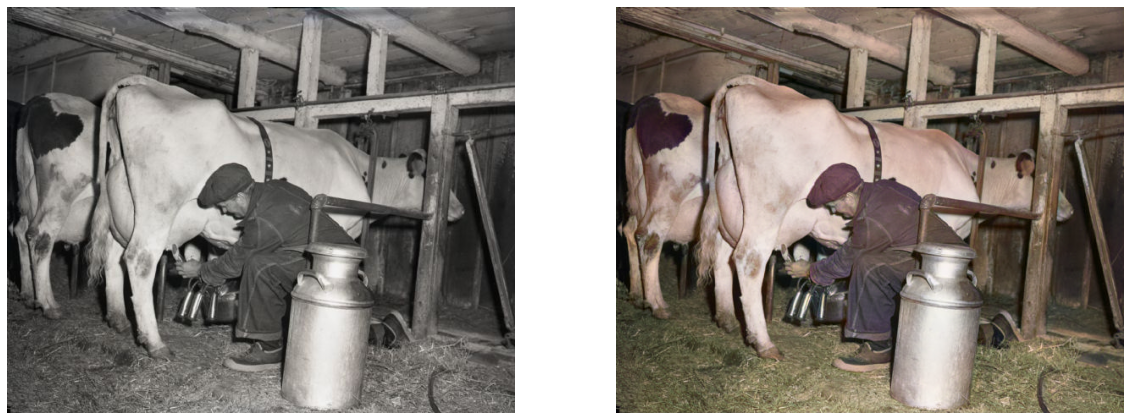

In [2]:
%cd /content/DeOldify
source_url = 'https://i.pinimg.com/originals/f1/dd/4c/f1dd4ca98416ae0db5061587810e7fd5.jpg' #@param {type:"string"}
render_factor = 35  #@param {type: "slider", min: 7, max: 40}
watermarked = True #@param {type:"boolean"}

if source_url is not None and source_url !='':
    image_path = colorizer.plot_transformed_image_from_url(url=source_url, render_factor=render_factor, compare=True, watermarked=watermarked)
    show_image_in_notebook(image_path)
else:
    print('Provide an image url and try again.')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os

Mounted at /content/drive


In [5]:
#build simple pandas frame with details about what file were processed.
import pandas as pd
import numpy as np

dtypes = np.dtype([
    ('date', np.datetime64),
    ('img_name', str),
    ('source_name',str),
    ('size', float),
    ('dimension', str)
])

image_df = pd.DataFrame(np.empty(0, dtype=dtypes))

print(image_df)

Empty DataFrame
Columns: [date, img_name, source_name, size, dimension]
Index: []


In [6]:
from datetime import datetime

current_datetime = datetime.now()
test_name_dict = {'E1':{'date':current_datetime, 'img_name':'test1.jpg', 'source_name':'final1.jpg', 'size':7.3,'dimension':'480x310'},
                  'E2':{'date':current_datetime, 'img_name':'test2.jpg', 'source_name':'final2.jpg', 'size':7.9,'dimension':'480x250'},
                  'E3':{'date':current_datetime, 'img_name':'test3.jpg', 'source_name':'final3.jpg', 'size':7.5,'dimension':'480x450'} }

image_df = image_df.append({'date': current_datetime, 'img_name': 'test_img', 'source_name':'final4.jpg', 'size':11.2, 'dimension':'860x480'}, ignore_index=True)

for i_key, val in test_name_dict.items():
  image_df = image_df.append({'date': val['date'], 'img_name': val['img_name'], 'source_name':val['source_name'], 'size':val['size'], 'dimension':val['dimension']}, ignore_index=True)

print(image_df)

                        date   img_name source_name  size dimension
0 2023-01-03 07:36:51.037773   test_img  final4.jpg  11.2   860x480
1 2023-01-03 07:36:51.037773  test1.jpg  final1.jpg   7.3   480x310
2 2023-01-03 07:36:51.037773  test2.jpg  final2.jpg   7.9   480x250
3 2023-01-03 07:36:51.037773  test3.jpg  final3.jpg   7.5   480x450


In [7]:
import os

import enum

# Enum for size units
class SIZE_UNIT(enum.Enum):
   BYTES = 1
   KB = 2
   MB = 3
   GB = 4


def convert_unit(size_in_bytes, unit):
   """ Convert the size from bytes to other units like KB, MB or GB"""
   if unit == SIZE_UNIT.KB:
       return size_in_bytes/1024
   elif unit == SIZE_UNIT.MB:
       return size_in_bytes/(1024*1024)
   elif unit == SIZE_UNIT.GB:
       return size_in_bytes/(1024*1024*1024)
   else:
       return size_in_bytes


def get_file_size(file_name, size_type = SIZE_UNIT.BYTES ):
   """ Get file in size in given unit like KB, MB or GB"""
   size = os.path.getsize(file_name)
   return convert_unit(size, size_type)

   

In [ ]:
#Make sure that we have the correct working directory set
%cd /content/drive/MyDrive/Github/bw_photos/

#setup matching dictionary for mapping into file to output file.
file_mapping = {}

#get a list of all the files and directories within the correct working directory
files_dir = os.listdir()

base_folder_path = os.getcwd()
print(f'Working in this current directory: {base_folder_path}')
for single_file_obj in files_dir:
  if( single_file_obj.endswith('.jpg') ):
    #Now get just the files that are jpg for processing.
    print(f'found a jpg file for processing: {single_file_obj}')
    
    #taking jpg file that have spaces between words and replacing with underscore
    processed_file_nm = single_file_obj.replace(' ', '_')
    color_output_full_file_nm = f'color_{processed_file_nm}'
    color_full_path = os.path.join(base_folder_path,'colorized',color_output_full_file_nm)
    print(f'Here is where the processed file is being put: {color_full_path}')

    #record source to output file mapping.
    file_mapping[color_output_full_file_nm] = single_file_obj

    #Now do the actually color processing.
    bw_full_file_path = os.path.join(base_folder_path,single_file_obj)
    print(f'Here is the bw path: {bw_full_file_path}')
    img_pic = colorizer.plot_transformed_image(bw_full_file_path, render_factor=35, display_render_factor=True, figsize=(10,10))
    #print(type(img_pic))

    #Now build the full file path where it is in the results and copy to drive.
    full_results_loc = os.path.join(base_folder_path,'result_images', single_file_obj)
    #Now copy
    !cp "$full_results_loc" $color_full_path

    print('Finished moving to the next one **********************************************************************************')


In [9]:
print(file_mapping)

{'color_img073.jpg': 'img073.jpg', 'color_Klempel_Family_Homestead.jpg': 'Klempel Family Homestead.jpg', 'color_Herman_Nollmeyer.jpg': 'Herman Nollmeyer.jpg', 'color_Girls_at_homestead.jpg': 'Girls at homestead.jpg', 'color_Katze.jpg': 'Katze.jpg', 'color_Katze_Kids.jpg': 'Katze Kids.jpg', 'color_img317.jpg': 'img317.jpg', 'color_img321.jpg': 'img321.jpg'}


In [10]:
from PIL import Image

img_filename = '/content/drive/MyDrive/Github/bw_photos/colorized/color_img321.jpg'
with Image.open(img_filename) as image:
    width, height = image.size
    print(f'Here is the width: {width}. Here is the height: {height}')


# get file size in KB
size = get_file_size(img_filename, SIZE_UNIT.KB)
print('Size of file is : ', size ,  'KB')

rnd_size = round(size,3)
print(f'Here is the value that is rounded: {rnd_size} KB')

Here is the width: 2856. Here is the height: 2256
Size of file is :  974.767578125 KB
Here is the value that is rounded: 974.768 KB


In [11]:

from datetime import datetime


col_dtypes = np.dtype([
    ('date', np.datetime64),
    ('img_name', str),
    ('source_name',str),
    ('size', float),
    ('unit_size', str),
    ('dimension', str)
])


#Make sure that we have the correct working directory set
#Going to do book-keeping on the color phots.
%cd /content/drive/MyDrive/Github/bw_photos/colorized/

image_df = pd.DataFrame(np.empty(0, dtype=col_dtypes))
current_datetime = datetime.now()

#get a list of all the files and directories within the correct working directory
color_files_dir = os.listdir()

base_folder_path = os.getcwd()
print(f'Working in this current directory: {base_folder_path}')
for single_file_obj in color_files_dir:
  if( single_file_obj.endswith('.jpg') ):
    #Now get just the files that are jpg for processing.
    print(f'found a color jpg file for processing: {single_file_obj}')
    
    #Get the size and dimension for the file for bookkeeping
    color_img_fl = os.path.join(base_folder_path, single_file_obj)

    #Get the size of the image.
    color_img_size = None
    with Image.open(color_img_fl) as image:
      color_img_dim = image.size

    formatted_color_img_size = round( get_file_size( color_img_fl, SIZE_UNIT.KB), 3)


    #Put requested info into dataframe
    image_df = image_df.append({'date': current_datetime, 'img_name': single_file_obj, 'source_name':file_mapping[single_file_obj], 'size':formatted_color_img_size, 'unit_size': 'KB', 'dimension':color_img_dim}, ignore_index=True)

    

    print('Finished moving to the next one **********************************************************************************')

/content/drive/MyDrive/Github/bw_photos/colorized
Working in this current directory: /content/drive/MyDrive/Github/bw_photos/colorized
found a color jpg file for processing: color_img073.jpg
Finished moving to the next one **********************************************************************************
found a color jpg file for processing: color_Klempel_Family_Homestead.jpg
Finished moving to the next one **********************************************************************************
found a color jpg file for processing: color_Herman_Nollmeyer.jpg
Finished moving to the next one **********************************************************************************
found a color jpg file for processing: color_Girls_at_homestead.jpg
Finished moving to the next one **********************************************************************************
found a color jpg file for processing: color_Katze.jpg
Finished moving to the next one ******************************************************

In [12]:
print(image_df)

                        date                            img_name  \
0 2023-01-03 07:51:15.398051                    color_img073.jpg   
1 2023-01-03 07:51:15.398051  color_Klempel_Family_Homestead.jpg   
2 2023-01-03 07:51:15.398051          color_Herman_Nollmeyer.jpg   
3 2023-01-03 07:51:15.398051        color_Girls_at_homestead.jpg   
4 2023-01-03 07:51:15.398051                     color_Katze.jpg   
5 2023-01-03 07:51:15.398051                color_Katze_Kids.jpg   
6 2023-01-03 07:51:15.398051                    color_img317.jpg   
7 2023-01-03 07:51:15.398051                    color_img321.jpg   

                    source_name     size unit_size     dimension  
0                    img073.jpg  443.753        KB  (1752, 2370)  
1  Klempel Family Homestead.jpg  202.915        KB   (1314, 767)  
2          Herman Nollmeyer.jpg  229.163        KB   (972, 1572)  
3        Girls at homestead.jpg  159.537        KB   (1140, 846)  
4                     Katze.jpg  328.866        KB  

In [13]:
%pwd

'/content/drive/MyDrive/Github/bw_photos/colorized'

In [14]:
image_df.to_excel('image_info_excel.xlsx', sheet_name='images_info', index=False )